## Segmentasyonlu Görüntüler Üzerinde İşlemler

## Data 

- Bu veri kümesi 3 sınıflı **15.000 histopatolojik görüntü** içermektedir. Tüm görüntüler **768 x 768 piksel** boyutunda ve **jpeg** dosya formatındadır.
- Görüntüler, toplam 750 akciğer dokusu görüntüsünden (250 iyi huylu akciğer dokusu, 250 akciğer adenokarsinomu ve 250 akciğer skuamöz hücreli karsinomu) oluşan HIPAA uyumlu ve onaylanmış kaynakların orijinal bir örneğinden oluşturulmuş ve Augmentor paketi kullanılarak 15.000'e yükseltilmiştir.
- Veri kümesinde her biri 5.000 görüntü içeren üç sınıf bulunmaktadır:
    * **Lung benign tissue (iyi huylu doku) ==> lung_n**
    * **Lung adenocarcinoma(adenokarsinom) ==> lung_aca**
    * **Lung squamous cell carcinoma(skuamöz hücreli karsinom) ==> lung_scc**  

In [3]:
import numpy as np # np is short for numpy
import pandas as pd # pandas is so commonly used, it's shortened to pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns
import tensorflow as tf
import os

# We want our plots to appear in the notebook
%matplotlib inline 

## Models
from tensorflow.keras.models import Sequential

## Layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout #for Overfiting Problem

## Preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping #for Overfiting Problem
from tensorflow.keras.utils import plot_model
from matplotlib.image import imread
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image


## Model evaluators
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

#Load Model
from tensorflow.keras.models import load_model

In [4]:
import splitfolders

In [6]:
splitfolders.ratio('Mask',output='segmentation_lung_data_split',ratio=(.7,.2,.1))

Copying files: 15000 files [00:16, 928.53 files/s] 


# Verimizi: %70’i train, %20’si val, %10’u test olarak ayırdık.

In [4]:
#load data direction
data_dir = 'segmentation_lung_data_split'

In [5]:
#what our data include
os.listdir(data_dir)

['test', 'train', 'val']

In [6]:
train_data_dir = data_dir+'\\train\\'
val_data_dir = data_dir+'\\val\\'
test_data_dir = data_dir+'\\test\\'

In [7]:
os.listdir(train_data_dir)

['otsu_masks_aca', 'otsu_masks_n', 'otsu_masks_scc']

In [8]:
os.listdir(test_data_dir)

['otsu_masks_aca', 'otsu_masks_n', 'otsu_masks_scc']

In [9]:
os.listdir(val_data_dir)

['otsu_masks_aca', 'otsu_masks_n', 'otsu_masks_scc']

In [12]:
import os
import pandas as pd

# Ana veri dizini
data_dir = 'segmentation_lung_data_split'
subsets = ['train', 'val', 'test']
class_folders = ['otsu_masks_aca', 'otsu_masks_n', 'otsu_masks_scc']

# Veri bilgilerini toplayacağımız liste
data_info = []

# Her bir subset için döngü
for subset in subsets:
    subset_dir = os.path.join(data_dir, subset)
    for class_name in class_folders:
        class_path = os.path.join(subset_dir, class_name)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            data_info.append([subset, class_name, num_images])
        else:
            data_info.append([subset, class_name, 0])  # Klasör yoksa 0

# Sonuçları DataFrame olarak gösterelim
df_data_info = pd.DataFrame(data_info, columns=["Subset", "Class", "Number of Images"])
df_data_info

Subset           Class  Number of Images
0  train  otsu_masks_aca              3500
1  train    otsu_masks_n              3500
2  train  otsu_masks_scc              3500
3    val  otsu_masks_aca              1000
4    val    otsu_masks_n              1000
5    val  otsu_masks_scc              1000
6   test  otsu_masks_aca               500
7   test    otsu_masks_n               500
8   test  otsu_masks_scc               500

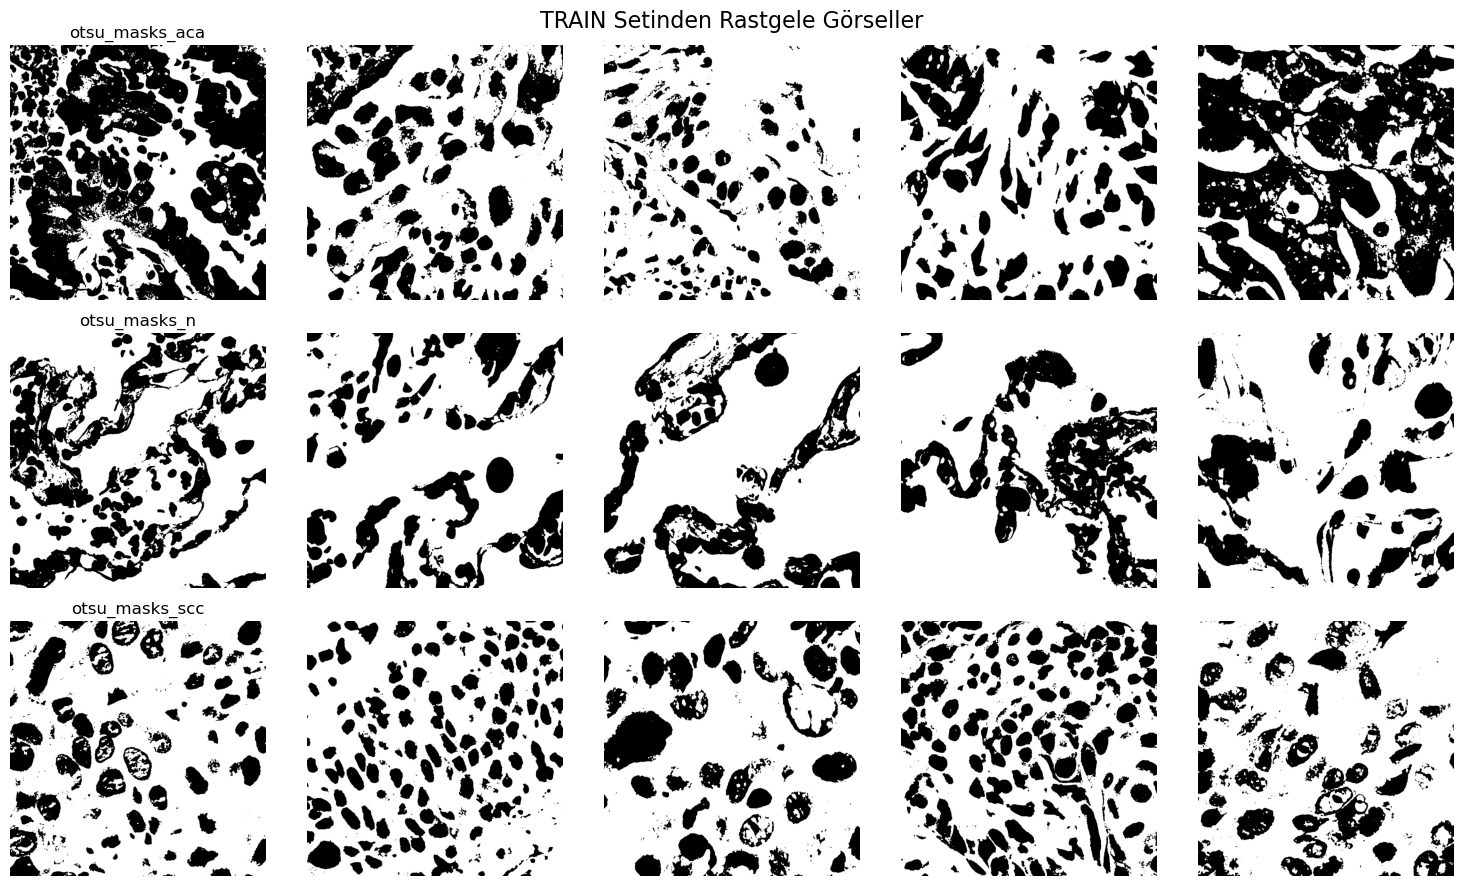

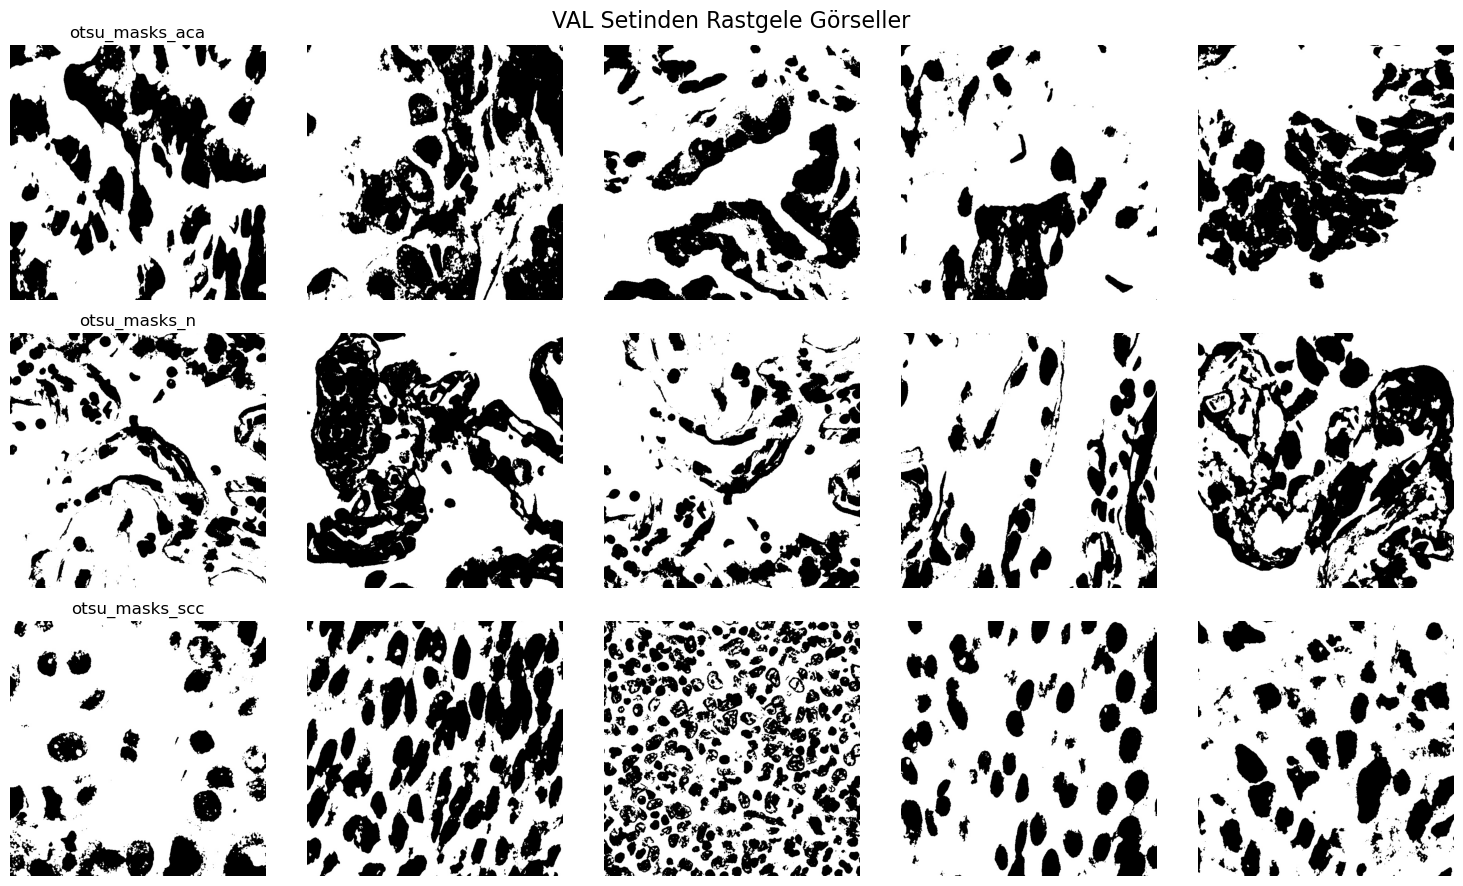

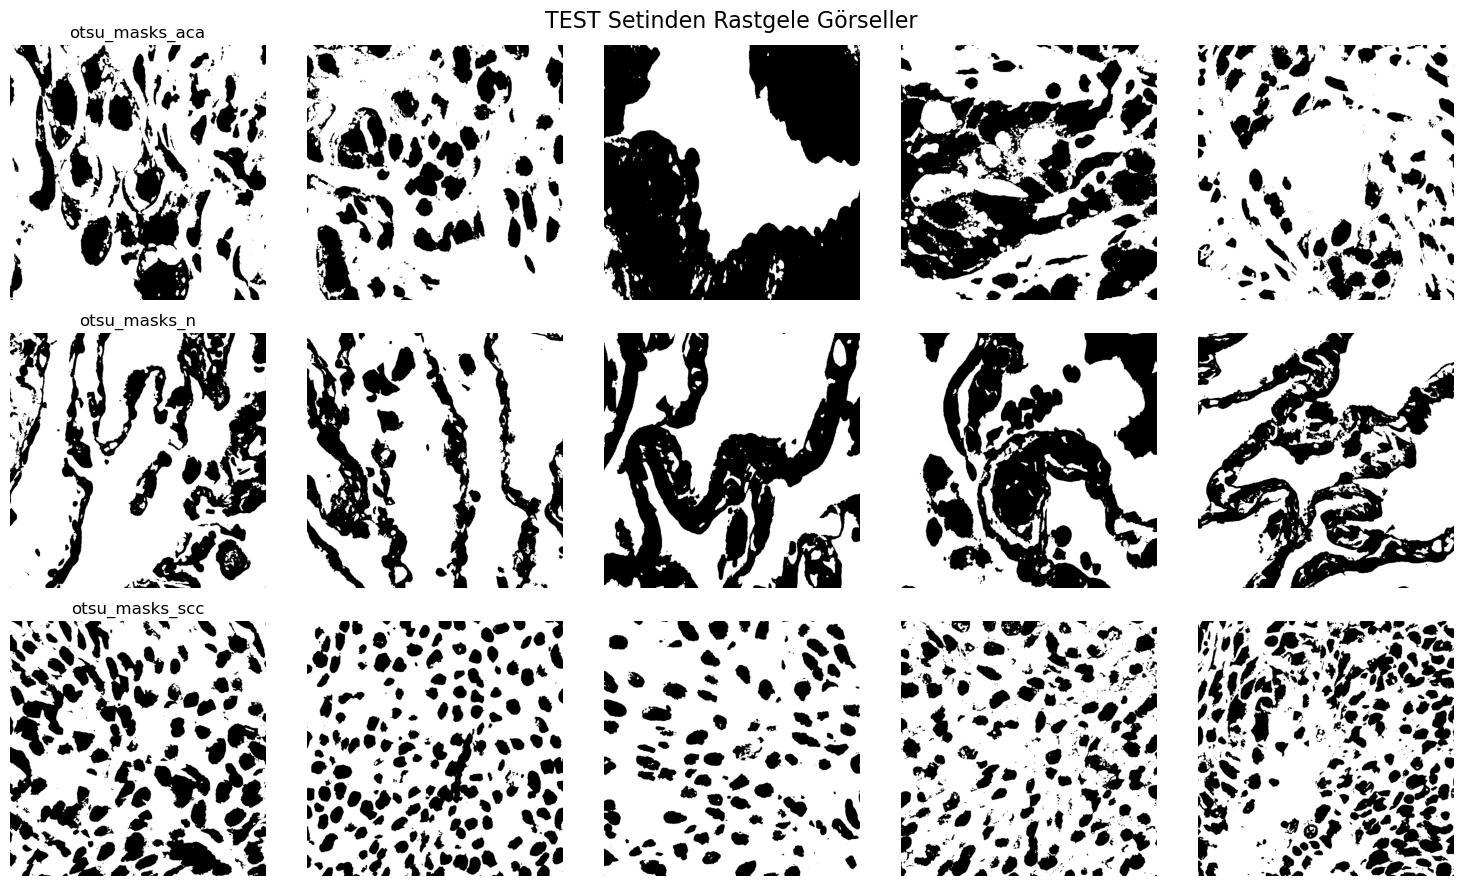

In [13]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Ana klasör ve ayarlar
data_dir = "segmentation_lung_data_split"
subsets = ["train", "val", "test"]
class_names = ['otsu_masks_aca', 'otsu_masks_n', 'otsu_masks_scc']
num_samples = 5  # Her sınıftan kaç örnek gösterileceği

# Rastgele seçilen görüntü yollarını saklayacağımız sözlük
image_samples = {}  # Yapısı: {subset: {class_name: [img_paths]}}

for subset in subsets:
    subset_path = os.path.join(data_dir, subset)
    image_samples[subset] = {}
    for class_name in class_names:
        class_path = os.path.join(subset_path, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            selected_images = random.sample(images, min(num_samples, len(images)))
            image_samples[subset][class_name] = [os.path.join(class_path, img) for img in selected_images]

# Görselleştirme
for subset in subsets:
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 9))
    fig.suptitle(f"{subset.upper()} Setinden Rastgele Görseller", fontsize=16)
    for i, class_name in enumerate(class_names):
        for j, img_path in enumerate(image_samples[subset].get(class_name, [])):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)  # Başlık altı boşluğu ayarlama
    plt.show()

## Preparing the Data(Verinin Hazırlanması)

### Data Augmentation(Veri Artırımı)

* Görüntü Büyütme tekniğini uygulayarak görüntü eğitim veri setinin boyutunu yapay olarak artıracağız.

In [14]:
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                               rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True
                              )

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale=1./255)

### 7.2 Loading the Images

In [16]:
train =image_gen.flow_from_directory(
                                     train_data_dir,
                                     target_size=(150,150),
                                     color_mode='grayscale',
                                     class_mode='categorical',
                                     batch_size=32
                                    )

test =test_data_gen.flow_from_directory(
                                         test_data_dir,
                                         target_size=(150,150),
                                         color_mode='grayscale',
                                         class_mode='categorical',
                                         batch_size=32,
                                         shuffle=False
                                        )
# setting shuffle as False just so we can later compare it with predicted values without having indexing problem

valid =test_data_gen.flow_from_directory(
                                         val_data_dir,
                                         target_size=(150,150),
                                         color_mode='grayscale',
                                         class_mode='categorical',
                                         batch_size=32,
                                        )



Found 10500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [17]:
train.class_indices

{'otsu_masks_aca': 0, 'otsu_masks_n': 1, 'otsu_masks_scc': 2}

In [19]:
lung_aca_names = os.listdir(train_data_dir+'\\otsu_masks_aca\\')
lung_aca_names[:5]

['lungaca100.jpeg',
 'lungaca1000.jpeg',
 'lungaca1001.jpeg',
 'lungaca1002.jpeg',
 'lungaca1003.jpeg']

In [20]:
lung_n_names = os.listdir(train_data_dir+'\\otsu_masks_n\\')
lung_n_names[:5]

['lungn100.jpeg',
 'lungn1000.jpeg',
 'lungn1001.jpeg',
 'lungn1002.jpeg',
 'lungn1003.jpeg']

In [21]:
lung_scc_names = os.listdir(train_data_dir+'\\otsu_masks_scc\\')
lung_scc_names[:5]

['lungscc100.jpeg',
 'lungscc1000.jpeg',
 'lungscc1001.jpeg',
 'lungscc1002.jpeg',
 'lungscc1003.jpeg']

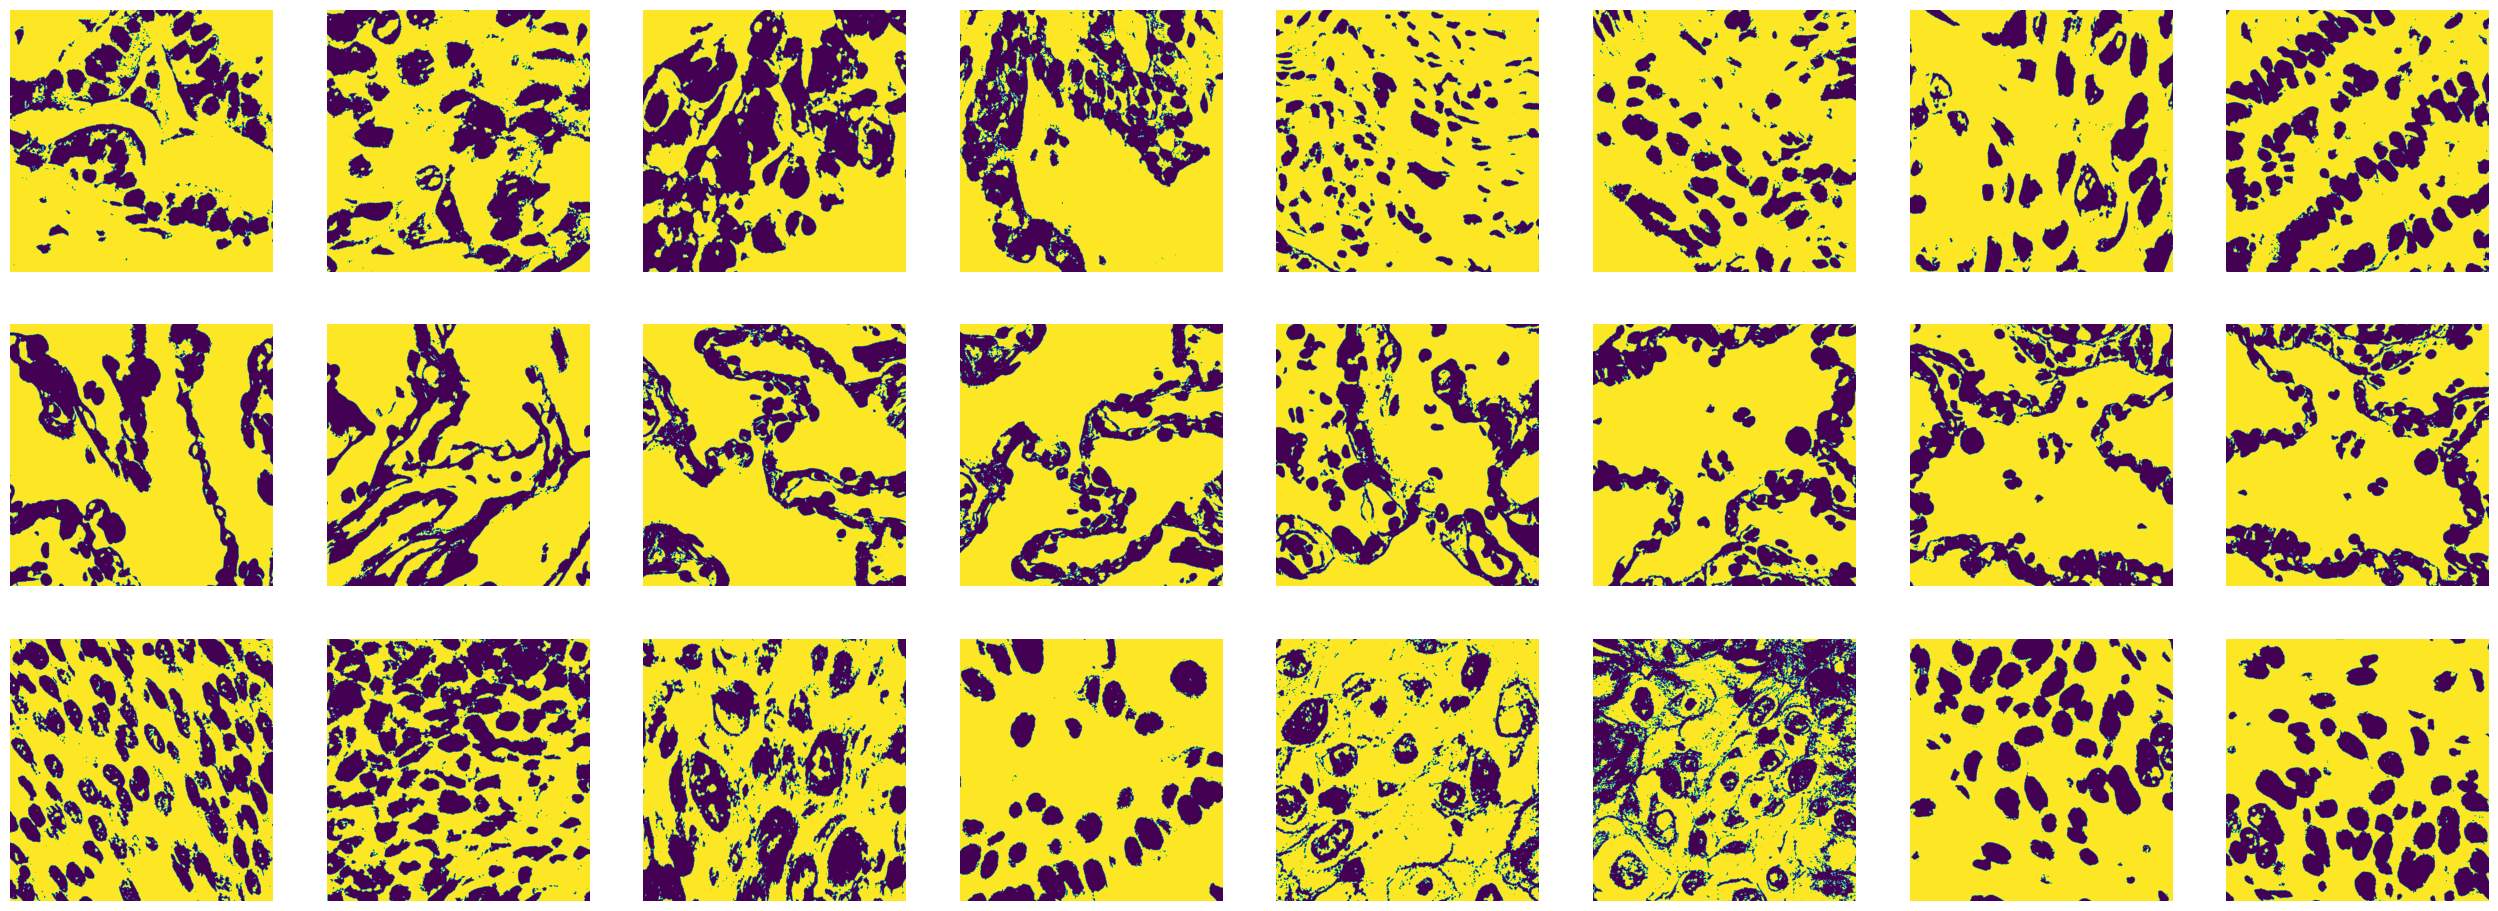

In [22]:
# parameters for the graph. The images will be in a 4x4 configuration
nrows = 8
ncols = 8

pic_index = 0 #index for iterating over images

#set up matplotlib figure
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

otsu_masks_aca_pic = [os.path.join(train_data_dir+'\\otsu_masks_aca\\', fname) for fname in lung_aca_names[pic_index-8:pic_index]]
otsu_masks_n_pic = [os.path.join(train_data_dir+'\\otsu_masks_n\\', fname) for fname in lung_n_names[pic_index-8:pic_index]]
otsu_masks_scc_pic = [os.path.join(train_data_dir+'\\otsu_masks_scc\\', fname) for fname in lung_scc_names[pic_index-8:pic_index]]


for i, img_path in enumerate(otsu_masks_aca_pic + otsu_masks_n_pic + otsu_masks_scc_pic):
    # setting up subplot. subplots start at index 1
    sub = plt.subplot(nrows, ncols, i + 1)
    sub.axis("off") #turning off axis. Don't show axis
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

#1-Lung adenocarcinoma 
#2-Lung benign tissue
#3-Lung squamous cell carcinoma 

In [41]:
#Define the model Layers (Define The model)
model =Sequential() 

# first convolution
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))

# second convolution
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Third convolution
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# flatten before feeding into Dense neural network. 
model.add(Flatten())
          
# 512 neurons in the hidden layer          
model.add(Dense(512,activation='relu'))
          
model.add(Dropout(rate=0.4))       
 
#3 = 3 different categories
    # softmas takes a set of values and effectively picks the biggest one. for example if the output layer has
    # [0.1,0.1,0.5], it will take it and turn it into [0,0,1]    
model.add(Dense(3,activation='softmax'))          

#Compiling the model

optmz = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')

model.compile(optimizer =optmz,loss="categorical_crossentropy",metrics=['accuracy'])

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,527,747 (36.35 MB)

 Trainable params: 9,527,747 (36.35 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
#Defining Callback list
early = EarlyStopping(monitor='val_loss',patience=2,mode='min')

In [44]:
#Fit The model
model.fit(train,epochs=25,validation_data=valid)

Epoch 1/25


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 179s 534ms/step - accuracy: 0.4595 - loss: 1.0335 - val_accuracy: 0.5760 - val_loss: 0.9321
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 251ms/step - accuracy: 0.5763 - loss: 0.8913 - val_accuracy: 0.6863 - val_loss: 0.7251
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 251ms/step - accuracy: 0.6934 - loss: 0.6922 - val_accuracy: 0.6890 - val_loss: 0.7180
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - accuracy: 0.7572 - loss: 0.5904 - val_accuracy: 0.7750 - val_loss: 0.5390
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.7823 - loss: 0.5151 - val_accuracy: 0.8003 - val_loss: 0.4694
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 245ms/step - accuracy: 0.8160 - loss: 0.4453 - val_accuracy: 0.8153 - val_loss: 0.4495
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.8331 - loss: 0.4116 - val_accuracy: 0.8133 - val_loss: 0.4286
Epoch 8/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.8461 - loss: 0.3775 - va

In [45]:
#Display Data Frame , to show result 
losses = pd.DataFrame(model.history.history)
losses

accuracy      loss  val_accuracy  val_loss
0   0.509048  0.989289      0.576000  0.932142
1   0.610095  0.847310      0.686333  0.725113
2   0.711524  0.655797      0.689000  0.717961
3   0.756381  0.576099      0.775000  0.539001
4   0.790476  0.499819      0.800333  0.469375
5   0.809429  0.450254      0.815333  0.449474
6   0.837238  0.398912      0.813333  0.428595
7   0.848095  0.369143      0.838000  0.389825
8   0.866190  0.339853      0.841333  0.390604
9   0.882286  0.305955      0.882333  0.286872
10  0.892476  0.279217      0.895333  0.253225
11  0.906476  0.252956      0.902667  0.247594
12  0.914571  0.227704      0.879667  0.320071
13  0.928286  0.202376      0.870333  0.331526
14  0.928476  0.190050      0.908000  0.249825
15  0.940381  0.167962      0.920667  0.209123
16  0.941714  0.157668      0.922333  0.218571
17  0.946857  0.150011      0.927667  0.199859
18  0.953524  0.136137      0.934667  0.184396
19  0.957143  0.125364      0.931667  0.182475
20  0.956952  0.122873      0.935667  0.200930
21  0.965810  0.097871      0.941333  0.184939
22  0.966286  0.098077      0.944333  0.163329
23  0.968762  0.091193      0.926000  0.235934
24  0.970190  0.087993      0.921667  0.262968

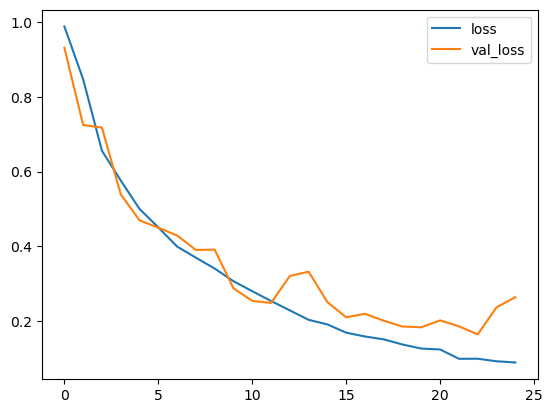

In [46]:
losses[['loss','val_loss']].plot();

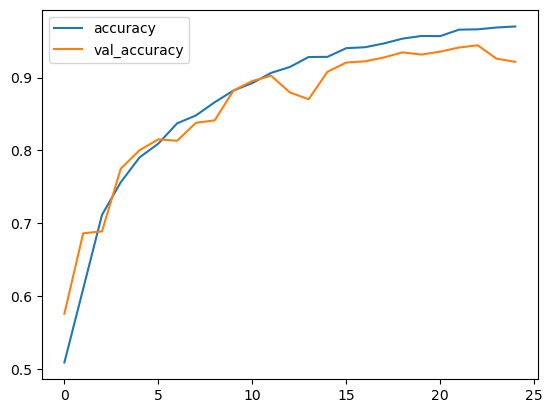

In [47]:
losses[['accuracy','val_accuracy']].plot();

In [50]:
test_steps_per_epoch = np.math.ceil(test.samples / test.batch_size)
predictions = model.predict(test, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test.classes
class_labels = list(test.class_indices.keys())   
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

C:\Windows\Temp\ipykernel_21488\2825146019.py:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test.samples / test.batch_size)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step
                precision    recall  f1-score   support

otsu_masks_aca       0.87      0.91      0.89       500
  otsu_masks_n       0.99      0.86      0.92       500
otsu_masks_scc       0.89      0.96      0.93       500

      accuracy                           0.91      1500
     macro avg       0.92      0.91      0.91      1500
  weighted avg       0.92      0.91      0.91      1500



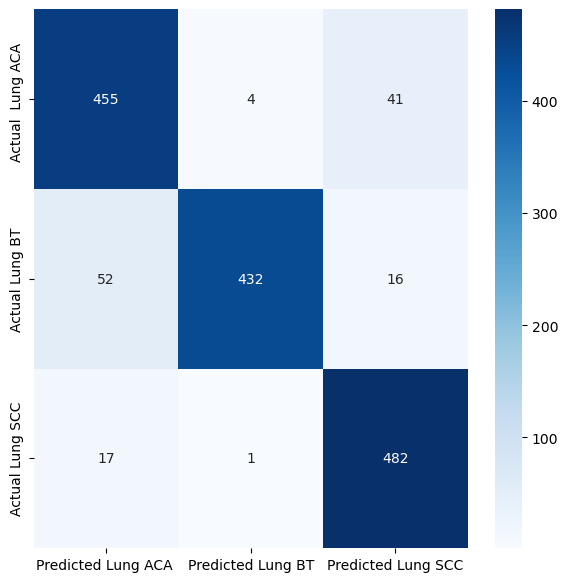

In [51]:
plt.subplots(figsize=(7,7))
cm = confusion_matrix(true_classes,predicted_classes)
cm_df =pd.DataFrame(cm,
                    columns=['Predicted Lung ACA ','Predicted Lung BT','Predicted Lung SCC'],
                    index=['Actual  Lung ACA ','Actual Lung BT','Actual Lung SCC'])

sns.heatmap(cm_df,annot=True,cmap="Blues", fmt='.0f');

## Modeli Kaydetme

In [52]:
#Save The Model 
model.save("lung_cancer.h5")

### Kaydedilen Modeli Test Etme

In [58]:
model.input_shape

(None, 150, 150, 1)

In [61]:
test_image = "Mask/otsu_masks_aca/lungaca10.jpeg"

# Görseli gri tonlamalı (1 kanal) yükle
img = image.load_img(test_image, target_size=(150, 150), color_mode='grayscale')

# Görseli modele uygun formata çevir
array = image.img_to_array(img)         # (150,150,1)
x = np.expand_dims(array, axis=0)       # (1,150,150,1)

# Tahmin et
test_image = model.predict(x)
result = test_image.argmax(axis=-1)

# Sınıf adını yazdır
if result == [2]:
    print('Lung squamous cell carcinoma')
elif result == [0]:
    print('Lung Adenocarcinoma')
elif result == [1]:
    print('Lung benign tissue')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Lung Adenocarcinoma


In [62]:
test_image = "Mask/otsu_masks_n/lungn27.jpeg"

# Görseli gri tonlamalı (1 kanal) yükle
img = image.load_img(test_image, target_size=(150, 150), color_mode='grayscale')

# Görseli modele uygun formata çevir
array = image.img_to_array(img)         # (150,150,1)
x = np.expand_dims(array, axis=0)       # (1,150,150,1)

# Tahmin et
test_image = model.predict(x)
result = test_image.argmax(axis=-1)

# Sınıf adını yazdır
if result == [2]:
    print('Lung squamous cell carcinoma')
elif result == [0]:
    print('Lung Adenocarcinoma')
elif result == [1]:
    print('Lung benign tissue')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Lung benign tissue


In [63]:
test_image = "Mask/otsu_masks_scc/lungscc41.jpeg"

# Görseli gri tonlamalı (1 kanal) yükle
img = image.load_img(test_image, target_size=(150, 150), color_mode='grayscale')

# Görseli modele uygun formata çevir
array = image.img_to_array(img)         # (150,150,1)
x = np.expand_dims(array, axis=0)       # (1,150,150,1)

# Tahmin et
test_image = model.predict(x)
result = test_image.argmax(axis=-1)

# Sınıf adını yazdır
if result == [2]:
    print('Lung squamous cell carcinoma')
elif result == [0]:
    print('Lung Adenocarcinoma')
elif result == [1]:
    print('Lung benign tissue')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Lung squamous cell carcinoma


## Modeli Yükleme

In [64]:
#Load Model
model_dir= 'lung_cancer.h5'

# loading using .h5 file
new_lung_model = tf.keras.models.load_model(
    "lung_cancer.h5",
    custom_objects=None,
    compile=True)

In [65]:
loss,acc = new_lung_model.evaluate(valid, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

94/94 - 9s - 93ms/step - accuracy: 0.9217 - loss: 0.2630
Restored model, accuracy: 92.17%
